$\newcommand{\ket}[1]{\left|#1\right>}$

$\newcommand{\bra}[1]{\left<#1\right|}$

$\newcommand{\braket}[2]{\left<#1 | #2\right>}$

# Decoherence

Everything here is taken from the IBM quantum computing User Guide and introduction to quantum computing:

https://quantum-computing.ibm.com/docs/guide/wwwq/decoherence

The presence of noise in the environment surrounding the qbit can induce a loss of information, also called $\it{decoherence}$.

This makes the $\it{pure states}$ we described until now to become $\it{mixed states}$.

While pure states can be represented as vectors of unit length that touch the Bloch sphere surface, the mixed states are $\it{shorter}$ and stay inside the Bloch sphere.

Additionally, while pure states can be represented in density matrix form as:

$\rho =  \ket{\psi} \bra{\psi}$

mixed states are expressed as linear combinations of pure states:

$\rho =  \sum_k p_k \ket{\psi_k} \bra{\psi_k}$

We are going to see two processes that can induce decoherence:
- Energy relaxation 
- Dephasing

## Energy Relaxation and $T_1$

Qbits in the excited state $\ket{1}$ tend to go back to the fundamental state $\ket{0}$, with a time constant $T_1$. The largest the time constant, the more stable a qbit is.

To measure $T_1$, we can create several circuits in which we put a qbit in the $\ket{1}$ state, then one or more identity gates (which do nothing more than wait) and measure its state. An example of code to do this follows.

In [4]:
# t1.py
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute, IBMQ

provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# Build the circuits
pre = QuantumCircuit(1, 1)
pre.x(0)
pre.barrier()
meas = QuantumCircuit(1, 1)
meas.measure(0, 0)
circuits = []
exp_vector = range(1,51)
for exp_index in exp_vector:
    middle = QuantumCircuit(1, 1)
    for i in range(45*exp_index):
        middle.iden(0)
    circuits.append(pre + middle + meas)
    

In [12]:
# Draw the first circuit
# this is the one with less Id gates,
# or the one that takes less time to measure the qbit state
circuits[0].draw()

┌───┐ ░ ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
q_0: |0>┤ X ├─░─┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
        └───┘ ░ └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
 c_0: 0 ════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
«q_0: ┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
«     └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
«c_0: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
«q_0: ┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
«     └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
«c_0: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌─┐
«q_0: ┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤M├
«     └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└╥┘
«c_0: ═══════════════════════════════════════════════════════════════════╩═
«

In [8]:
# Execute the circuits
shots = 1024

# Select the backend (in this case, the ibmq_rome quantum computer)
# Here we are not doing a simulation, but measuring the T1 of this particular real quantum computer!
backend = provider.get_backend('ibmq_rome')
job = execute(circuits, backend, shots=shots)
result = job.result()

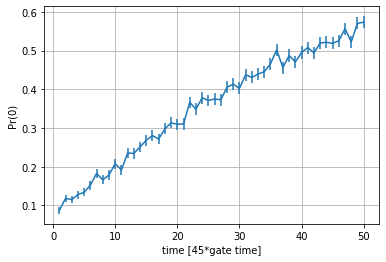

In [9]:
# Plot the result
exp_data = []
exp_error = []
for idx, _ in enumerate(exp_vector):
    data = result.get_counts(idx)
    try:
        p0 = data['0']/shots
    except KeyError:
        p0 = 0
    exp_data.append(p0)
    exp_error.append(np.sqrt(p0*(1-p0)/shots))

plt.errorbar(exp_vector, exp_data, exp_error)
plt.xlabel('time [45*gate time]')
plt.ylabel('Pr(0)')
plt.grid(True)

## Dephasing and $T_2$

Dephasing is a process that affects qbits in superposition status, as for example:

$\ket{+} = \dfrac{\ket{0} + \ket{1}}{\sqrt{2}}$

It consists in a rotation along the Z axis (or, equivalently, in the XY plane) of the vector state, if we consider the Bloch Sphere representation.

Depending on the way we measure it, its time constant goes under the name of $T_2$ or $T_2^*$.

A good reference to understand the differences between $T_2$ or $T_2^*$ is: <br>
https://quantumcomputing.stackexchange.com/questions/2432/whats-the-difference-between-t2-and-t2

Let's see it with a couple of examples.

### The Ramsey Experiment: measuring $T_2^*$

In this first experiment, we will put a qbit in the $\ket{+}$ state using a H gate:

$\ket{\psi} = \ket{+} = \dfrac{\ket{0} + \ket{1}}{\sqrt{2}}$

Then, we wait a certain time $\Delta t$, so that the state evolves as:

$\ket{\psi} = \dfrac{\ket{0} + e^{-i \Delta t}\ket{1}}{\sqrt{2}}$

After that, we apply again a H gate:

$H \ket{\psi} =  \dfrac{H \ket{0} + e^{-i \Delta t} H \ket{1}}{\sqrt{2}} = 
\dfrac{\ket{+} + e^{-i \Delta t} \ket{-}}{\sqrt{2}} = 
\dfrac{\ket{0} + \ket{1} + e^{-i \Delta t}(\ket{0} - \ket{1})}{2} = 
\dfrac{(1 + e^{-i \Delta t})\ket{0} + (1 - e^{-i \Delta t})\ket{1}}{2}$

This means that the probability of measuring $\ket{\psi} = \ket{0}$ is:

$ |\bra{0} \ket{\psi}|^2 = \dfrac{|(1 + e^{-i \Delta t})|^2}{4} = 
\cos^2(\dfrac{\Delta t}{2}) = \dfrac{1 + \cos(\Delta t)}{2}$

Let's see it with an example:

In [64]:
# t2_ramsey.py
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute

provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [65]:
# Build the circuits
pre = QuantumCircuit(1, 1)
pre.h(0)
pre.barrier()
meas_x = QuantumCircuit(1, 1)
meas_x.barrier()
meas_x.h(0)
meas_x.measure(0, 0)
circuits = []
exp_vector = range(1,51)
phase = 0.0
for exp_index in exp_vector:
    middle = QuantumCircuit(1, 1)
    #phase = phase + 6*np.pi/len(exp_vector)
    #middle.u1(phase,0)
    for i in range(25*exp_index):
        middle.iden(0)
    circuits.append(pre + middle + meas_x)

In [66]:
# Draw the first circuit
# this is the one with less Id gates,
# or the one that takes less time to measure the qbit state
circuits[0].draw()

┌───┐ ░ ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
q_0: |0>┤ H ├─░─┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
        └───┘ ░ └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
 c_0: 0 ════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
«q_0: ┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
«     └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
«c_0: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌────┐┌────┐┌────┐ ░ ┌───┐┌─┐
«q_0: ┤ Id ├┤ Id ├┤ Id ├─░─┤ H ├┤M├
«     └────┘└────┘└────┘ ░ └───┘└╥┘
«c_0: ═══════════════════════════╩═
«

In [67]:
# Execute the circuits
shots = 1024
backend = provider.get_backend('ibmqx2')
job = execute(circuits, backend, shots=shots)
result = job.result()

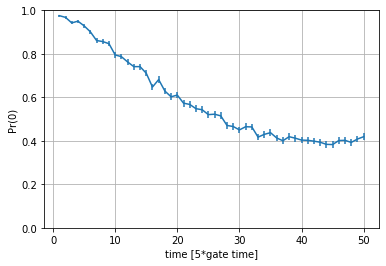

In [68]:
# Plot the result
exp_data = []
exp_error = []
for idx, _ in enumerate(exp_vector):
    data = result.get_counts(idx)
    try:
        p0 = data['0']/shots
    except KeyError:
        p0 = 0
    exp_data.append(p0)
    exp_error.append(np.sqrt(p0*(1-p0)/shots))

plt.errorbar(exp_vector, exp_data, exp_error)
plt.xlabel('time [25*gate time]')
plt.ylabel('Pr(0)')
plt.ylim(0,1)
plt.grid(True)

Why do we see that the evolution is not exactly as we would expect (it does not go to 0)? Is it because the $\ket{1}$ state not only rotate around Z, but also because it tends to go toward $\ket{0}$ with time?

Maybe the following example makes the question clearer

Alternatively, we can measure the state in the superposition basis. The original qskit tutorial does it with a trick, by applying a variable phase to the qbit state before waiting the qbit to evolve with time: 

In [81]:
# Build the circuits
pre = QuantumCircuit(1, 1)
pre.h(0)
pre.barrier()
meas_x = QuantumCircuit(1, 1)
meas_x.barrier()
meas_x.h(0)
meas_x.measure(0, 0)
circuits = []
exp_vector = range(1,51)
phase = 0.0
for exp_index in exp_vector:
    middle = QuantumCircuit(1, 1)
    phase = phase + 6*np.pi/len(exp_vector)
    # That's the 'trick'!!
    middle.u1(phase,0)
    for i in range(5*exp_index):
        middle.iden(0)
    circuits.append(pre + middle + meas_x)

In [82]:
# Draw the first circuit
# this is the one with less Id gates,
# or the one that takes less time to measure the qbit state

# Here we can see that we are applying a phase before 
# applying a set of Id operators!
circuits[0].draw()

┌───┐ ░ ┌─────────────┐┌────┐┌────┐┌────┐┌────┐┌────┐ ░ ┌───┐┌─┐
q_0: |0>┤ H ├─░─┤ U1(0.37699) ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├─░─┤ H ├┤M├
        └───┘ ░ └─────────────┘└────┘└────┘└────┘└────┘└────┘ ░ └───┘└╥┘
 c_0: 0 ══════════════════════════════════════════════════════════════╩═

In [83]:
# Execute the circuits
shots = 1024
backend = provider.get_backend('ibmqx2')
job = execute(circuits, backend, shots=shots)
result = job.result()

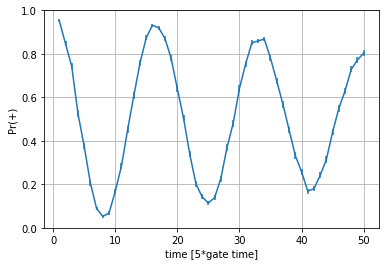

In [84]:
# Plot the result
exp_data = []
exp_error = []
for idx, _ in enumerate(exp_vector):
    data = result.get_counts(idx)
    try:
        p0 = data['0']/shots
    except KeyError:
        p0 = 0
    exp_data.append(p0)
    exp_error.append(np.sqrt(p0*(1-p0)/shots))

plt.errorbar(exp_vector, exp_data, exp_error)
plt.xlabel('time [5*gate time]')
plt.ylabel('Pr(+)')
plt.ylim(0,1)
plt.grid(True)

### The Echo Experiment: measuring $T_2$

In [27]:
# t2_echo.py
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, QuantumCircuit, execute

provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# Build the circuits
pre = QuantumCircuit(1, 1)
pre.h(0)
pre.barrier()
meas_x = QuantumCircuit(1, 1)
meas_x.barrier()
meas_x.h(0)
meas_x.measure([0], [0])
circuits = []
exp_vector = range(1,51)
for exp_index in exp_vector:
    middle = QuantumCircuit(1, 1)
    for i in range(15*exp_index):
        middle.iden(0)
    middle.x(0)
    for i in range(15*exp_index):
        middle.iden(0)
    circuits.append(pre + middle + meas_x)
    

In [31]:
# Draw the first circuit
# this is the one with less Id gates,
# or the one that takes less time to measure the qbit state
circuits[0].draw()

┌───┐ ░ ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
q_0: |0>┤ H ├─░─┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
        └───┘ ░ └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
 c_0: 0 ════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌────┐┌────┐┌────┐┌────┐┌────┐┌───┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
«q_0: ┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ X ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├»
«     └────┘└────┘└────┘└────┘└────┘└───┘└────┘└────┘└────┘└────┘└────┘└────┘»
«c_0: ═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«     ┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐ ░ ┌───┐┌─┐
«q_0: ┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├┤ Id ├─░─┤ H ├┤M├
«     └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘ ░ └───┘└╥┘
«c_0: ═══════════════════════════════════════════════════════════════╩═
«

In [32]:
# Execute the circuits
backend = provider.get_backend('ibmqx2')
job = execute(circuits, backend)
result = job.result()

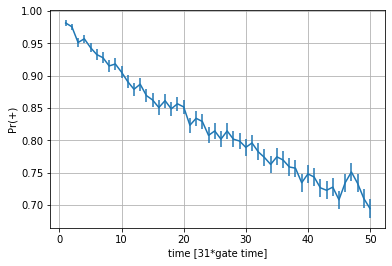

In [33]:
# Plot the result
exp_data = []
exp_error = []
for exp_index in exp_vector:
  data = result.get_counts(circuits[exp_index-1])
  try:
      p0 = data['0']/shots
  except KeyError:
      p0 = 0
  exp_data.append(p0)
  exp_error.append(np.sqrt(p0*(1-p0)/shots))

plt.errorbar(exp_vector, exp_data, exp_error)
plt.xlabel('time [31*gate time]')
plt.ylabel('Pr(+)')
plt.grid(True)